### This notebook brings in surface reflectance and pq for a polygon area
### Then calculates NDVI, then slope of NDVI for dry months (averaged yearly)

## Load modules

In [7]:
from scipy import stats



#----from NB1----#
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

## Function definitions : load and mask surface reflectance

In [8]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

### Bring in a shape file

In [10]:
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/kakadu_smaller.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
#choose the index of the polygon you want within the shape file
i =0
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
print(shape_name)

kakadu_smaller_0


### set up datacube query

In [11]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-nbart')

In [12]:
#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

In [13]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [14]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

### load in surface reflectance data for polygon 

In [15]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
did not load ls5_nbart_albers
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### concatenate sensor data

In [16]:
#make an array of all the clean sensor data
sensor_list = []
for sensor in [sensor1_nbart, sensor2_nbart, sensor3_nbart]:
    if sensor is not None:
        sensor_list.append(sensor)
nbart_allsensors = xr.concat(sensor_list,dim='time')

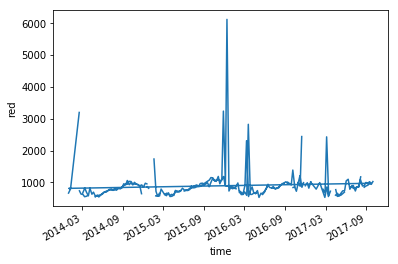

In [65]:
nbart_allsensors.red.mean(dim =('x','y')).plot()
plt.show()

In [49]:
del sensor_list
del sensor1_nbart
del sensor2_nbart
del sensor3_nbart

NameError: name 'sensor_list' is not defined

In [72]:
#checking that we are okay in terms of time sorting
nbart_allsensors =nbart_allsensors.sortby('time')

In [73]:
nbart_allsensors['NDVI'] = nbart_allsensors['nir']-nbart_allsensors['red']/nbart_allsensors['nir']-nbart_allsensors['red']

In [88]:
xr.__version__

'0.9.6'

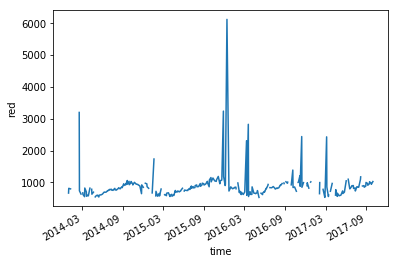

In [76]:
red_means = nbart_allsensors.red.mean(dim =('x','y'))
red_means.plot()
plt.show()

In [82]:
red_weirds = red_means.where(red_means>1500).dropna(dim='time')

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


In [83]:
len(red_weirds)

8

In [90]:
red_weirds.plot.imshow(col='time',col_wrap =4, cmap ='reds' )

ValueError: DataArray must be 2d

In [ ]:
 for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for {}'.format(sensor))
        return wbg    

In [50]:
%whos


Variable                  Type          Data/Info
-------------------------------------------------
bands_of_interest         list          n=6
datacube                  module        <module 'datacube' from '<...>es/datacube/__init__.py'>
dc                        Datacube      Datacube<index=Index<db=P<...>244.105:6432/datacube)>>>
end_of_epoch              str           2017-12-31
fiona                     module        <module 'fiona' from '/g/<...>kages/fiona/__init__.py'>
ga_pq_fuser               function      <function ga_pq_fuser at 0x7fe5f6b16268>
geo                       dict          n=2
geom                      Geometry      Geometry({'type': 'Polygo<...>0.017453292519943295]]'))
geom_bs                   Polygon       POLYGON ((132.84690787775<...>7594 -12.55002815634592))
geom_crs                  CRS           GEOGCS["GCS_WGS_1984",DAT<...>e",0.017453292519943295]]
geometry                  module        <module 'datacube.utils.g<...>acube/utils/geometry.py'>
i       

### calculate ndvi

### Linear regression code from Symington/Krause

##### month_cut from Neil - replace?

In [3]:
# DEfine functions
def month_cut(data, month_1, month_2):

    if data.dims[0] == 'time':
        sliced_xr = list(data.groupby('time.month'))[monthDict[month_1]:monthDict[month_2] + 1]
    elif data.dims[0] == 'month':
        sliced_xr = list(data.groupby('month'))[monthDict[month_1]:monthDict[month_2] + 1]
    
    #Concatenate all the arrays into one xarray
    split_xr = sliced_xr[0][1]

    
    for i in range(int(monthDict[month_2]) - int(monthDict[month_1])):
        split_xr = xr.concat([split_xr, sliced_xr[i+1][1]], dim = data.dims[0])
                     
    return split_xr

In [4]:
#Define important functions and dictionaries
# See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

#This function applies a linear regression to a grid over a set time interval
def linear_regression_grid(input_array, mask_no_trend = True, NDVI = False):
    '''
    This function applies a linear regression to a grid over a set time interval by looping through lat and lon 
    and calculating the linear regression through time for each pixel.
    '''

    ylen = len(input_array.y)
    xlen = len(input_array.x)
    from itertools import product
    coordinates = product(range(ylen), range(xlen))

    slopes = np.zeros((ylen, xlen))
    p_values = np.zeros((ylen, xlen))
    print('Slope shape is ', slopes.shape)

    for y, x in coordinates:
        val = input_array.isel(x = x, y = y)
        # If analysing NDVI data replace negative numbers which are spurious for NDVI with nans
        if NDVI == True:
            val[val<0] = np.nan

            # Check that we have at least three values to perform our linear regression on
            if np.count_nonzero(~np.isnan(val)) > 3:
                if str(val.dims[0]) == 'month':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
                elif str(val.dims[0]) == 'year':
                    slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)
            else:
                slopes[y, x] = np.nan
                intercept = np.nan
                r_sq = np.nan
                p_values[y, x] = np.nan
        else:
            if str(val.dims[0]) == 'month':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.month,val)
            elif str(val.dims[0]) == 'year':
                slopes[y, x], intercept, r_sq, p_values[y, x], std_err = stats.linregress(val.year,val)

    #Get coordinates from the original xarray
    lat  = input_array.coords['y']
    long = input_array.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_no_trend == True:
        slopes[p_values>0.05]=np.nan        
    # Write arrays into a x-array
    slope_xr = xr.DataArray(slopes, coords = [lat, long], dims = ['y', 'x'])
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x']) 
    return slope_xr, p_val_xr

In [5]:
#Finally we plot the regression for averaged daily or monthly data with a year(s) (eg. the May to October trend)
# If multiple years are chosen then the monthly data is averaged over multiple years (eg all October data over time period
# is averaged)

#Define time interval and months range
time_1 = '2012-01-01'
time_2 = '2016-12-31'
month_1 = 'April'
#You need at least 3 months to get a meaningful lilnear regression slope
month_2 = 'October'


cut_data = all_ndvi_sorted.loc[time_1:time_2]

averaged_data = cut_data.groupby('time.month').mean(dim='time')


#Now plot a grid for this data

month_cut(averaged_data, 'April', 'October')

slope_xr_ndvi, p_val_xr_ndvi = linear_regression_grid(averaged_data, mask_no_trend = False, NDVI = True)

fig = plt.figure(figsize =(11.69,5))
plt.imshow(slope_xr_ndvi)

plt.grid(True)
plt.colorbar()

plt.show()

NameError: name 'all_ndvi_sorted' is not defined